In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/Infected/omicron/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files['대구']
data

,stdDay,incDec,22D_variants,23A_variants
0,2022-12-19,973.0,467.04,9.73
1,2022-12-20,3625.0,1740.00,36.25
2,2022-12-21,3616.0,1735.68,36.16
3,2022-12-22,3197.0,1534.56,31.97
4,2022-12-23,2657.0,1275.36,26.57
...,...,...,...,...
132,2023-04-30,396.0,75.24,253.44
133,2023-05-01,122.0,23.18,78.08
134,2023-05-02,480.0,91.20,307.20
135,2023-05-03,464.0,88.16,296.96


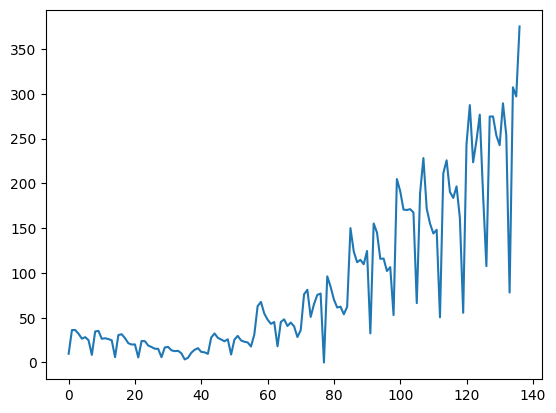

In [3]:
plt.plot(data['23A_variants'])

In [4]:
data[70:80]

,stdDay,incDec,22D_variants,23A_variants
70,2023-02-27,241.0,161.47,36.15
71,2023-02-28,507.0,339.69,76.05
72,2023-03-01,541.0,362.47,81.15
73,2023-03-02,339.0,227.13,50.85
74,2023-03-03,434.0,290.78,65.10
75,2023-03-04,503.0,337.01,75.45
76,2023-03-05,513.0,343.71,76.95
77,2023-03-06,0.0,0.00,0.00
78,2023-03-07,641.0,429.47,96.15
79,2023-03-08,564.0,377.88,84.60


In [5]:
path = 'hyperparameter/Infected/23A/*.pkl'
files = glob.glob(path)
dic_hyperparameter = {}
for file in files:
    dic_hyperparameter[file[28:-4]] = load_hyperparameter(file)
    
dic_hyperparameter

{'BiGRU': [132, 0.001, 20, 1, 32, 32, 0.25],
 'BiLSTM': [1273, 0.0001, 50, 1, 32, 8, 0.25],
 'BiRNN': [102, 0.001, 20, 1, 32, 32, 0.25],
 'GRU': [2024, 0.0001, 50, 1, 64, 32, 0.25],
 'LSTM': [1903, 0.0001, 50, 1, 64, 32, 0.25],
 'RNN': [437, 0.0001, 50, 1, 32, 32, 0.25],
 'seq2seq_BiGRU': [1014,
  0.001,
  50,
  4,
  64,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiLSTM': [1214,
  0.001,
  50,
  1,
  32,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiRNN': [343,
  0.001,
  20,
  1,
  64,
  32,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_GRU': [989,
  0.001,
  50,
  2,
  64,
  16,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_LSTM': [1084,
  0.001,
  50,
  4,
  64,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_RNN': [2636,
  0.0001,
  50,
  1,
  64,
  32,
  0.25,
  <function utils.criterion2(actual, predict)>]}

In [6]:
dic_model = load_model_multiple(dic_hyperparameter, 'Infected', '23A')

In [7]:
df = Prepare_df.processing(data, 'stdDay', '23A_variants')

predicted_values = {}
num_model = 0
for name, state in dic_model.items():
    batch_size = dic_hyperparameter[name][4]
    if num_model < 6:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 68, 60, 1, batch_size, 'mto')
        label_y, predicted = predict_mto(state, df, x_ss, y_ms)
        predicted_values[name] = [label_y, predicted]
    else:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 62, 60, 7, batch_size, 'mtm')
        label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
        predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]
        
    
    num_model += 1

In [8]:
actual_data = predicted_values['RNN'][0]

40.337045882263276


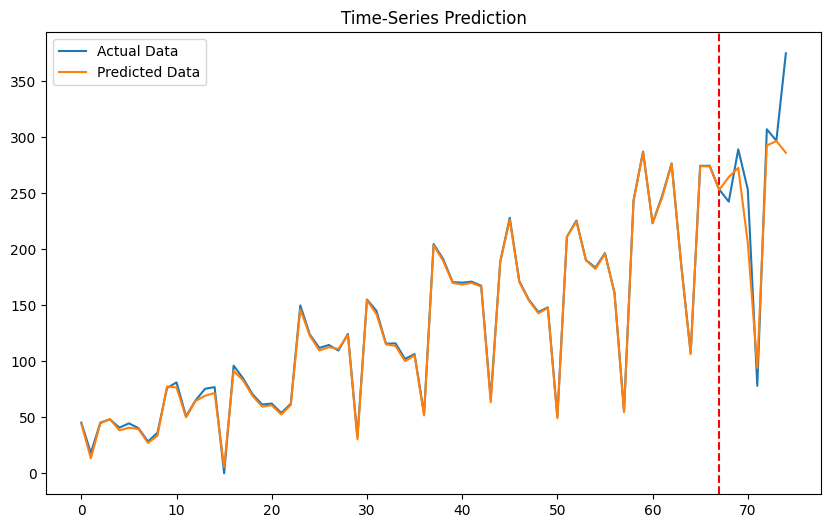

In [9]:
print(rmse(actual_data[-7:], predicted_values['RNN'][1][-7:]))
plotting(actual_data, predicted_values['RNN'][1], 67)

40.112578088405606


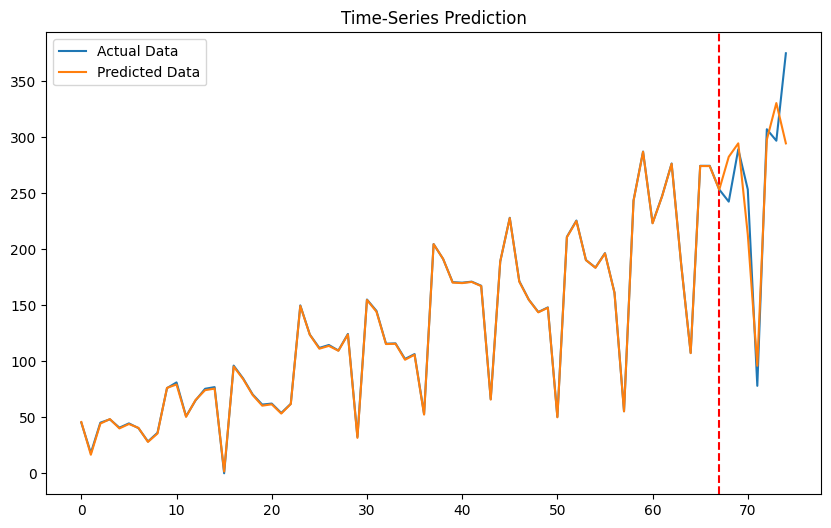

In [10]:
print(rmse(actual_data[-7:], predicted_values['LSTM'][1][-7:]))
plotting(actual_data, predicted_values['LSTM'][1], 67)

39.97450664661948


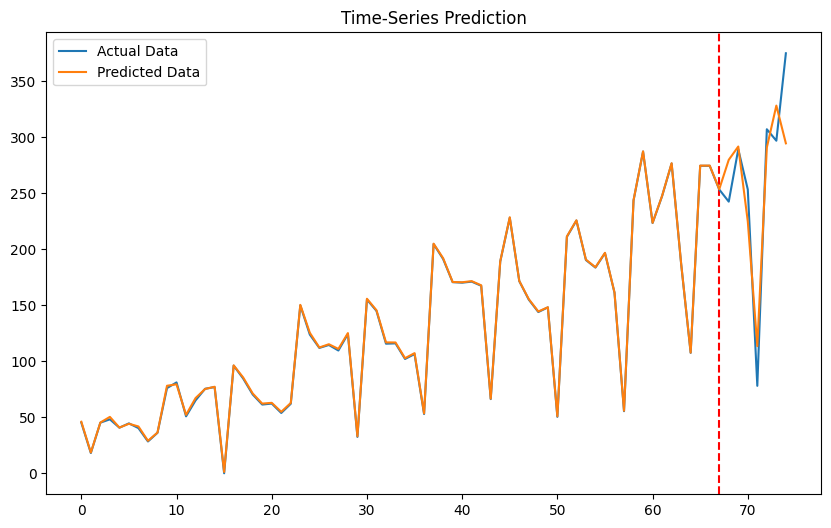

In [22]:
print(rmse(actual_data[-7:], predicted_values['GRU'][1][-7:]))
plotting(actual_data, predicted_values['GRU'][1], 67)

218.45897605442997


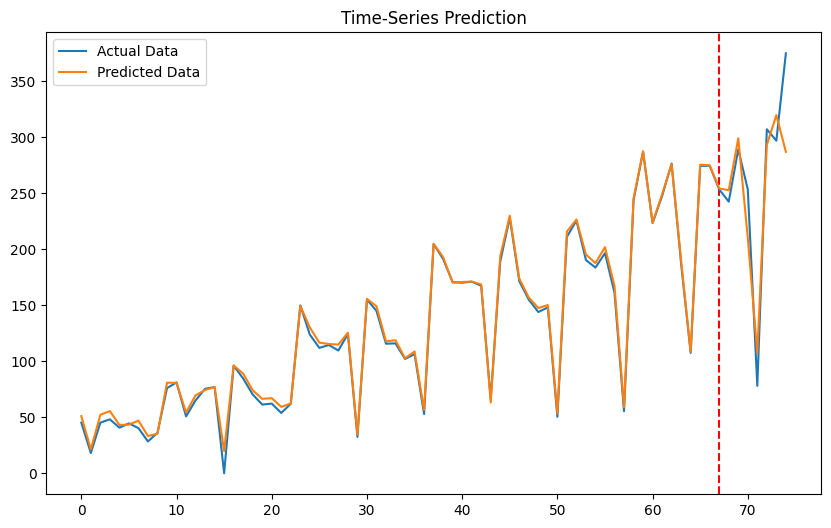

In [23]:
print(rmse(actual_data[0][-7:], predicted_values['BiRNN'][1][-7:]))
plotting(actual_data, predicted_values['BiRNN'][1], 67)

39.93078423092734


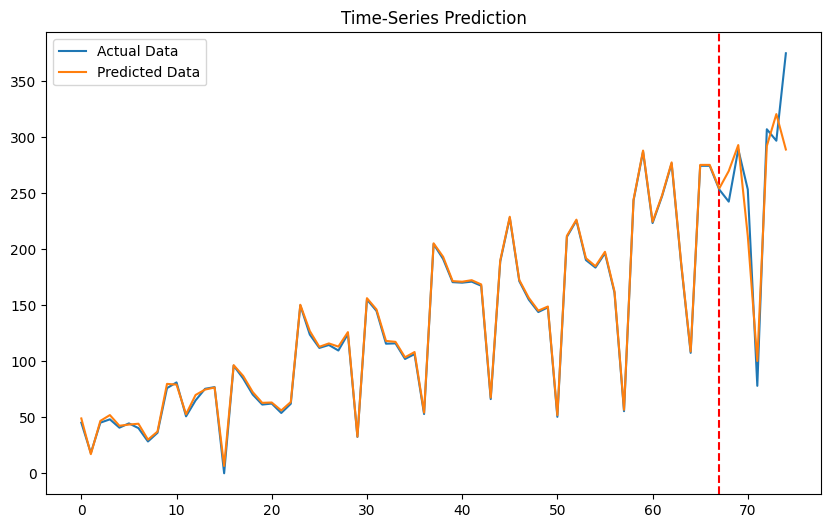

In [24]:
print(rmse(actual_data[-7:], predicted_values['BiLSTM'][1][-7:]))
plotting(actual_data, predicted_values['BiLSTM'][1], 67)

38.97560647880447


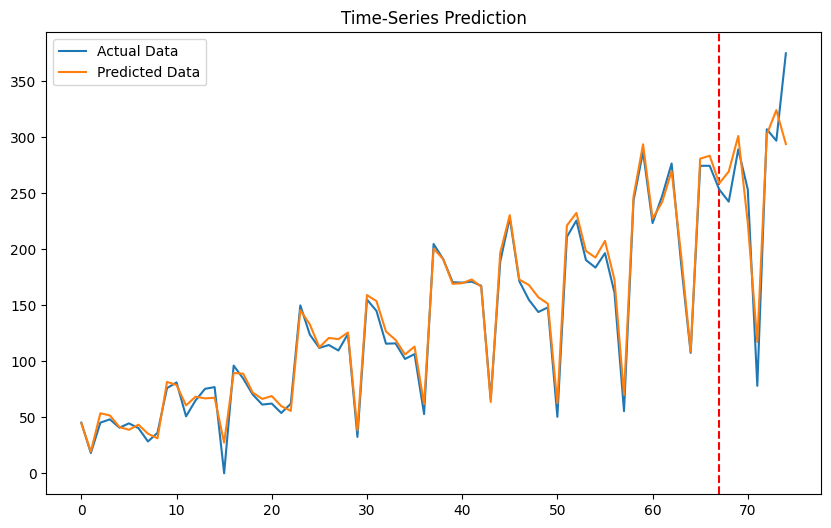

In [25]:
print(rmse(actual_data[-7:], predicted_values['BiGRU'][1][-7:]))
plotting(actual_data, predicted_values['BiGRU'][1], 67)

48.67457606871117


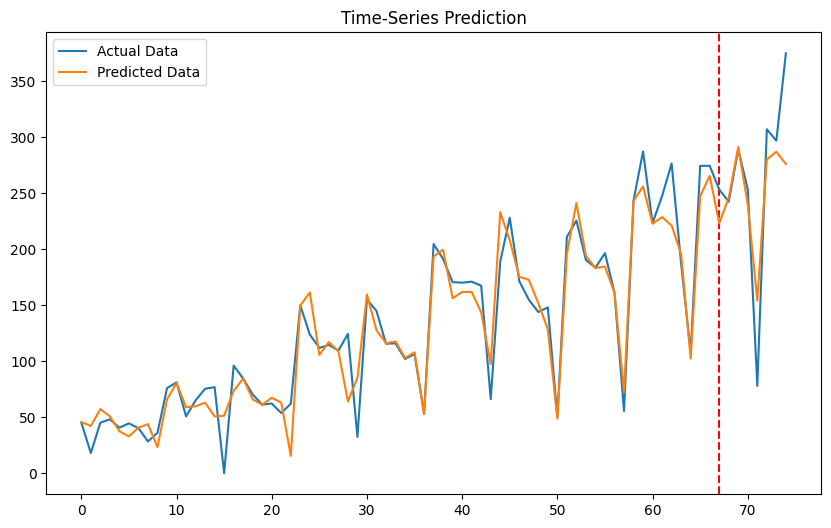

In [32]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_RNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_RNN'][4], 67)

52.36675100985477


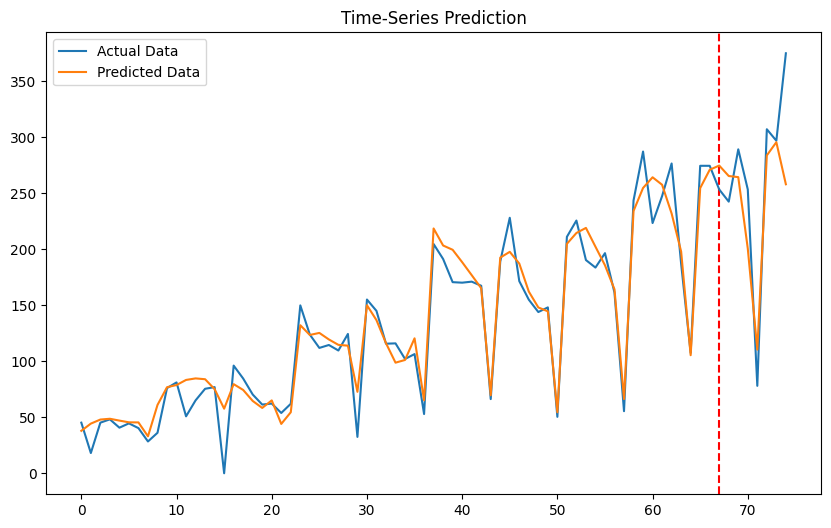

In [33]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_LSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_LSTM'][4], 67)

46.89768982100158


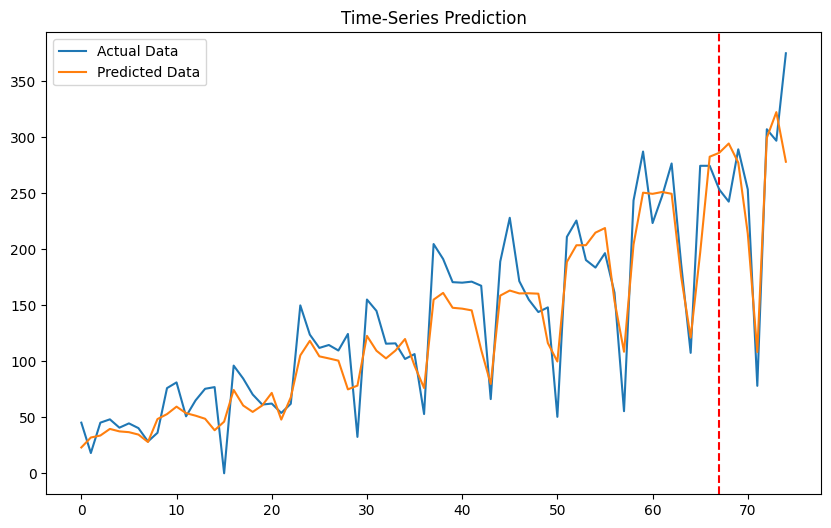

In [34]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_GRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_GRU'][4], 67)

61.13202525451574


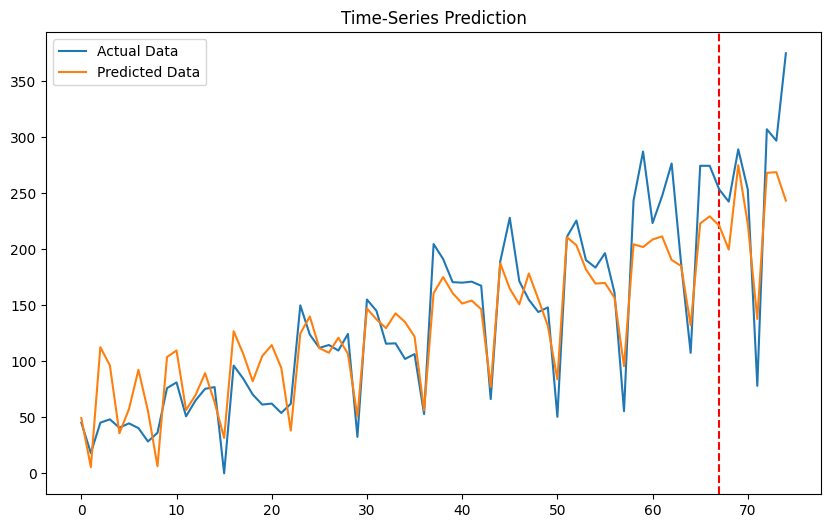

In [35]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiRNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiRNN'][4], 67)

57.25865407776256


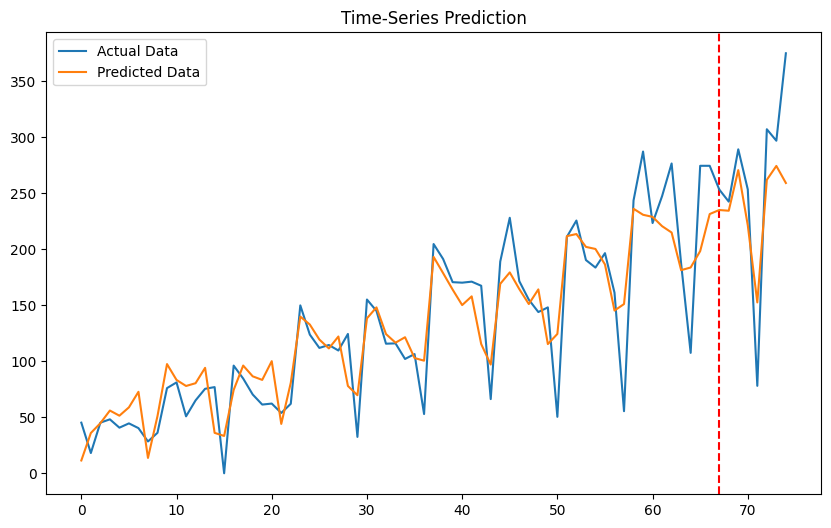

In [36]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiLSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiLSTM'][4], 67)

49.213065147885274


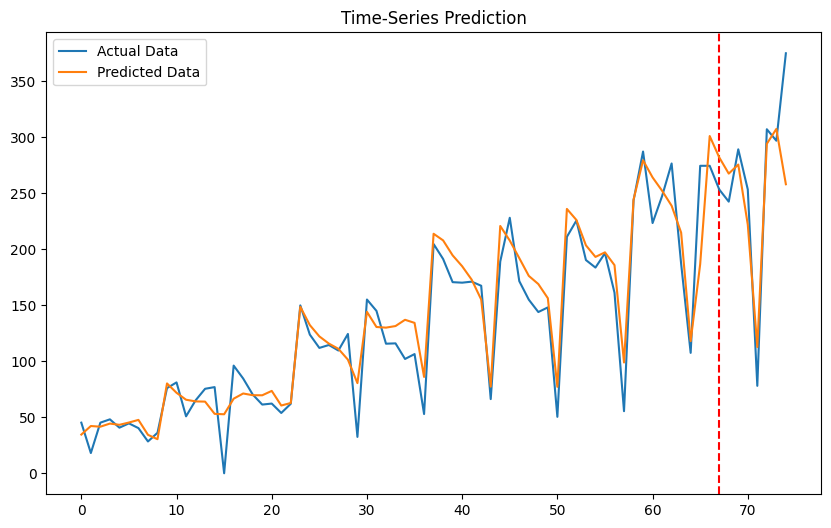

In [37]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiGRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiGRU'][4], 67)

In [40]:
best_model = 'BiGRU'
datetime_index = data['stdDay'][-1*len(actual_data):]
df_predicted = pd.DataFrame()
df_predicted = pd.DataFrame(np.concatenate([actual_data, predicted_values[best_model][1]], axis = 1), index = datetime_index, columns = ['22D_origin', '22D_Predicted'])
df_predicted.to_csv(f'Data/Predicted/Variants/Infected/23A_{best_model}.csv')

In [41]:
df_predicted

,22D_origin,22D_Predicted
stdDay,,
2023-02-19,45.200001,44.622189
2023-02-20,18.080000,19.297462
2023-02-21,45.200001,53.596310
2023-02-22,48.159996,51.650913
2023-02-23,40.719997,41.296974
...,...,...
2023-04-30,253.439987,223.499100
2023-05-01,78.080002,117.221939
2023-05-02,307.199982,302.630615
